# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
!pip install scikit-learn==1.2.2

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from scipy.stats import randint
from scipy.sparse import vstack
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from lightgbm import LGBMRegressor
import time

## Подготовка данных

In [3]:
def info(df):
    display(df.head())
    display(df.info())
    display(df.describe().T)
    display(df.isna().sum())
    print('Количество дубликатов: ',df.duplicated().sum())
    plt.figure(figsize=(10,5))
    corr_matrix = sns.heatmap(df.corr(),annot=True)
    corr_matrix.axes.set_title("Корреляционная матрица", fontsize=16)
    # Построение парных графиков
#     sns.pairplot(df);
    plt.show()

In [4]:
df=pd.read_csv('/datasets/autos.csv')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Количество дубликатов:  4


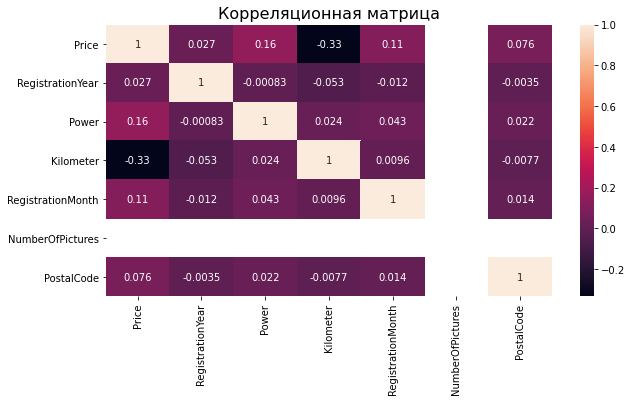

In [5]:
info(df)

### Вывод
Бибилотеки имортированы данные загружены



При изучении ДФ были выявленны следующие проблемы

- **Пропущены значения в колнках**

    VehicleType
    
    Gearbox
    
    Model
    
    FuelType
    
    Repaired
    
    
- Колонка **NumberOfPictures** сплошные 0

- А так же не понятные данные

    - в столбце **Price** присутвуют 0(маловероятные события,так как бесплтано машины не раздают)
    
    - в столбце **RegistrationYear** пристувуют машины старше 1000 лет
    
    - **Power** мощность автмобиля не может быть 0
    
Ну и 4 явных дубликата


## Второй этап подготовки данных

Иследование данных

- Временные данные

- Категориальные 

- Численные


In [6]:
#функция возврата усов
def moustache(col):
    irq = (col.quantile(0.75) - col.quantile(0.25))*3
    return max(col.quantile(0.25) - irq , col.min()), min(col.quantile(0.75) + irq,col.max())

**Год регистрации автомобиля**

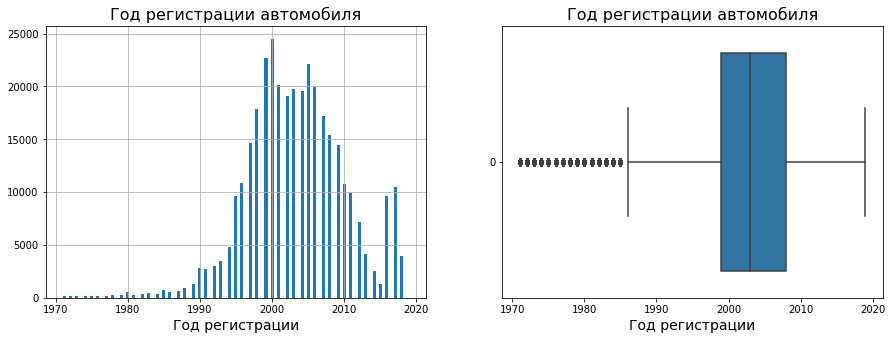

(1972.0, 2035.0)

In [7]:
fig = plt.figure(figsize=(15,5))

ax_1 = fig.add_subplot(1, 2, 1)
ax_1 = df[(df['RegistrationYear'] > 1970) & (df['RegistrationYear'] < 2023)]['RegistrationYear'].hist(bins=115)
ax_1.set_title('Год регистрации автомобиля', fontsize=16)
ax_1.set_xlabel('Год регистрации', fontsize=14)

ax_2 = fig.add_subplot(1, 2, 2)
ax_2 = sns.boxplot(data=df[(df['RegistrationYear'] > 1970) & (df['RegistrationYear'] < 2023)]['RegistrationYear'], orient='h')
ax_2.axes.set_title('Год регистрации автомобиля', fontsize=16)
ax_2.set_xlabel('Год регистрации', fontsize=14)

plt.show();
moustache(df['RegistrationYear'])

Проанализировав данные,можно сделать вывод

В целом данные распределены нормально за исключение 2015-2017 годов

Ящик с усами показывает нам,что данные ниже 1972 можно удалить а атк же все что выше 2016 соответтвенно


Записей с месяцем 0: 37352


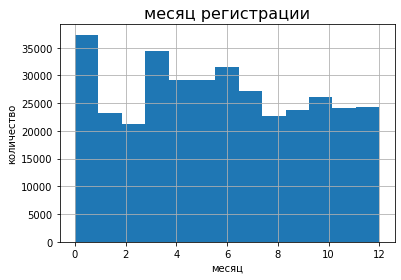

In [8]:
print('Записей с месяцем 0:',df[df['RegistrationMonth']==0].shape[0])
ax = df['RegistrationMonth'].hist(bins=13)
ax.set_title('месяц регистрации', fontsize=16)
ax.set(ylabel='количество', xlabel= 'месяц')
plt.show;

В целом данные распределены нормально,вопрос только месяц 0?

Возможно в месяце 0 храняться данные,месяц которых просто  не известен

Оставим его так как данных много

**Изучим категориальные данные**

**Тип кузова ТС**

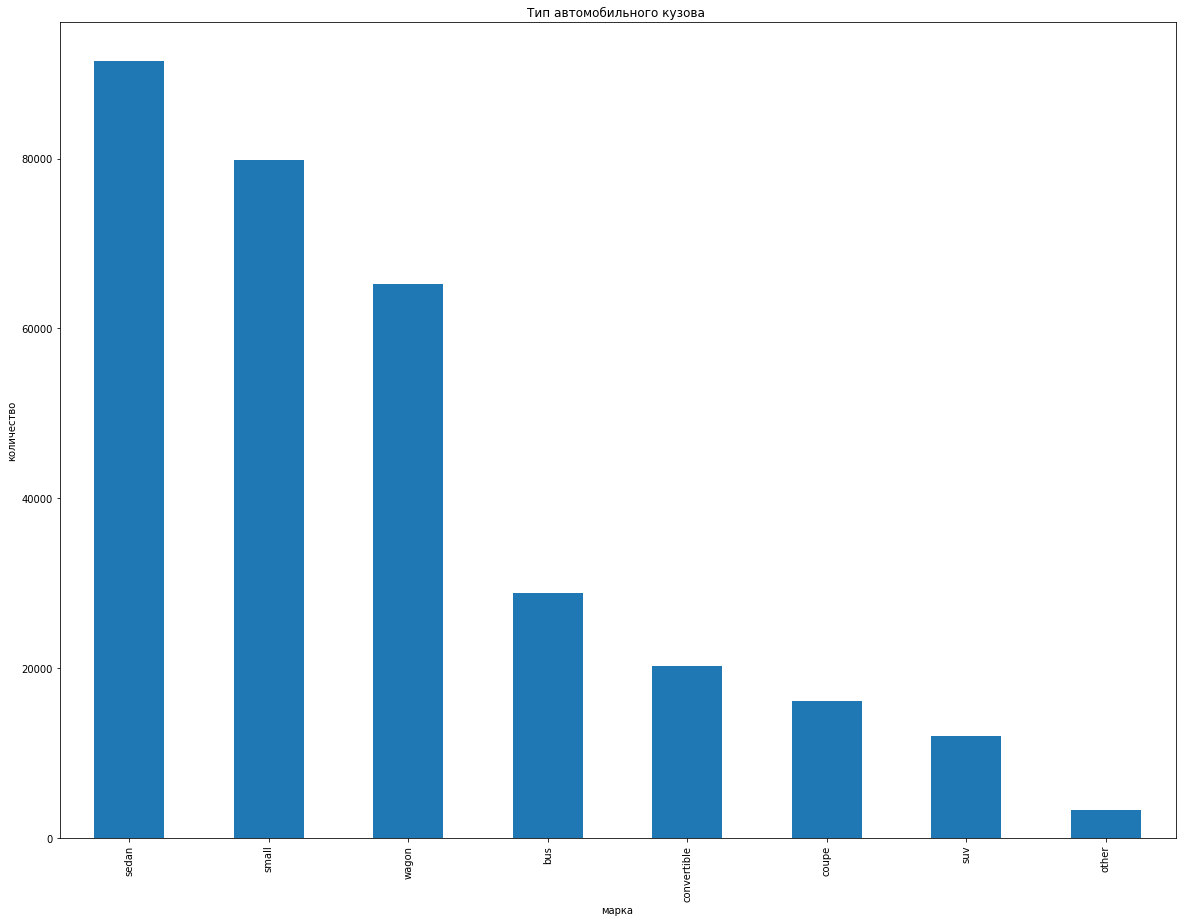

In [9]:
df['VehicleType'].value_counts().plot(kind='bar', 
                                      figsize=(20,15), 
                                      title='Тип автомобильного кузова ', 
                                      xlabel='марка',
                                      ylabel='количество');

**Марка ТС**

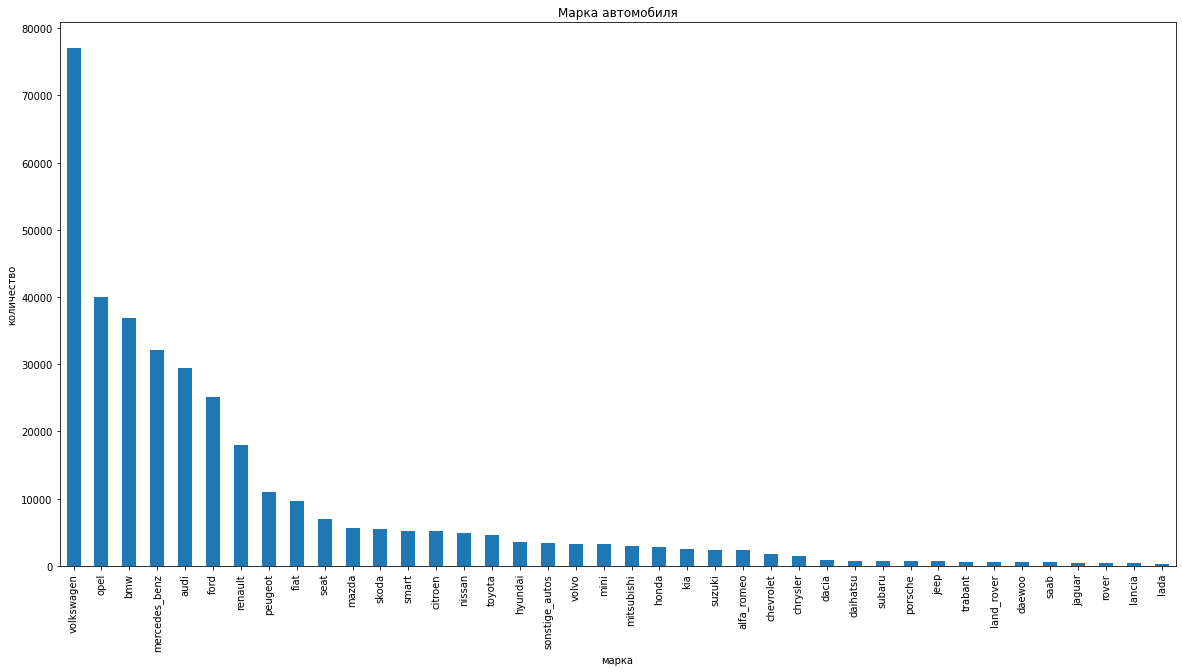

In [10]:
# Построение распределения марки автомобиля
df['Brand'].value_counts().plot(kind='bar', 
                                figsize=(20,10), 
                                title='Марка автомобиля',
                                xlabel='марка',
                                ylabel='количество',);

In [11]:
df['Brand'].value_counts()

volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64

**Модель**

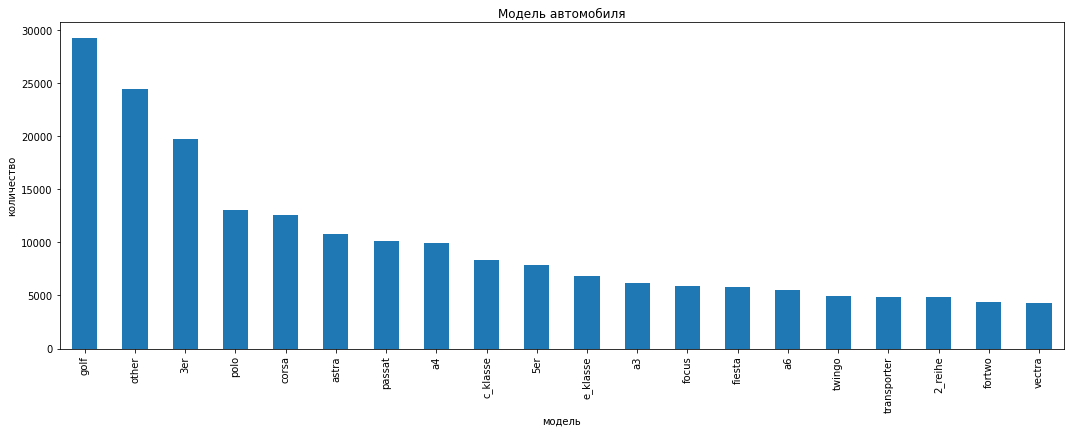

In [12]:
df['Model'].value_counts().head(20).plot(kind='bar', 
                                         figsize=(18,6), 
                                         title='Модель автомобиля',
                                         xlabel='модель',
                                         ylabel='количество',);

**Топливо**

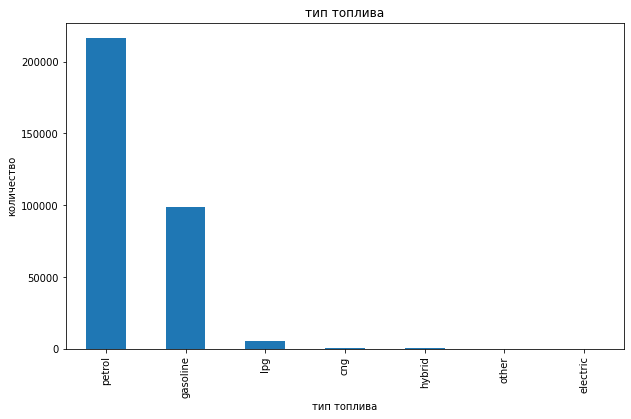

In [13]:
df['FuelType'].value_counts().plot(kind='bar', 
                                   figsize=(10,6), 
                                   title='тип топлива',
                                   xlabel='тип топлива',
                                   ylabel='количество',);


**Коробка**

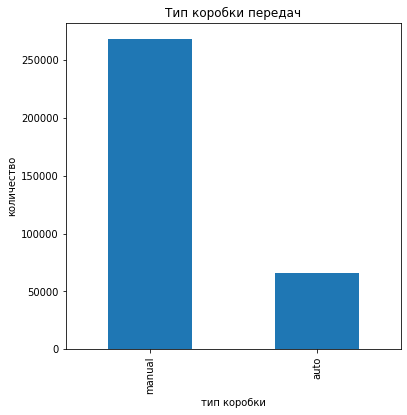

In [14]:
df['Gearbox'].value_counts().plot(kind='bar', 
                                  figsize=(6,6), 
                                  title='Тип коробки передач',
                                  xlabel='тип коробки',
                                  ylabel='количество',);

Проанализировав все графики видно,самый популярный тип ТС имеет

- Тип кузова седан

- Марка  **volkswagen**

- модель Golf

- Топливо Petrol

- Коробка механическая

**Численные данные**

In [15]:
def analiz(data, title, x_label):
    fig = plt.figure(figsize=(15,5))
    # Вывод гистограмы
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_1 = sns.histplot(data=data)
    ax_1.axes.set_title(title, fontsize=16)
    ax_1.set_xlabel(x_label, fontsize=14)
    
    # Вывод диаграмы размаха
    ax_2 = fig.add_subplot(1, 2, 2)
    ax_2 = sns.boxplot(data=data, orient='h')
    ax_2.axes.set_title(title, fontsize=16)
    ax_2.set_xlabel(x_label, fontsize=20)

    plt.show();

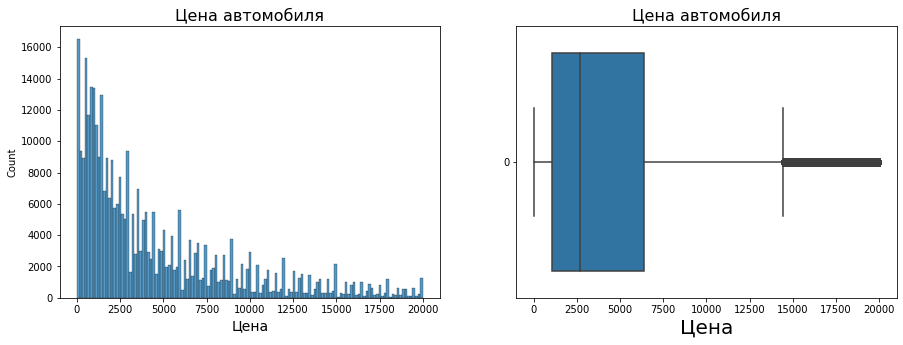

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [16]:
analiz(df['Price'], 'Цена автомобиля', 'Цена')
df['Price'].describe()

Исходя из графиков видно

- Много нулевых значений их придется удалить.

- А вот цена выше 20 тысяч евро вполне нормальная(так как владелец мог переделать авто под себя) их трогать небудем

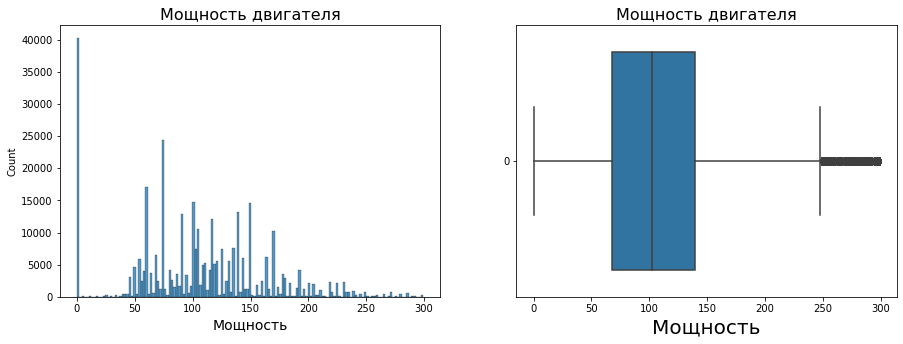

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [17]:
analiz(df[df['Power'] < 300]['Power'], 'Мощность двигателя', 'Мощность')
df['Power'].describe()

Из графиков делаю вывод что

- Минималльная мощность авто определяю 60 л.с

- Максимальная не более 250,значение выше тысячи поделим на 10,значение выше 1000 поделим на 100(возможно ошибка в данных)

Так как авто с мощностью меньше 60 л.с 17% от общего числа,данные удалять не будем-это много


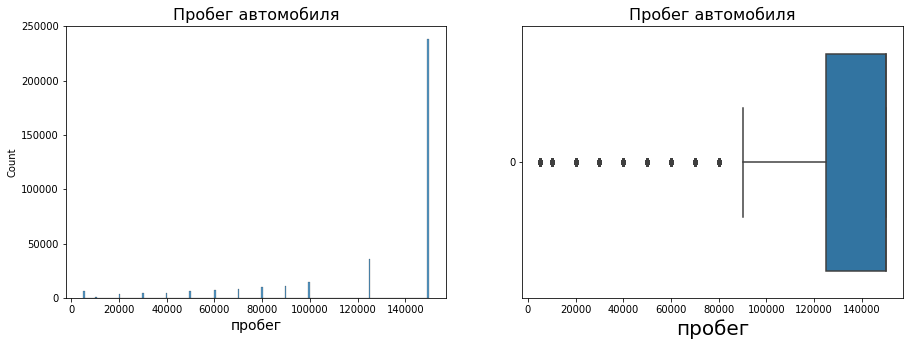

count    354369.000000
mean     128211.172535
std       37905.341530
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

In [18]:
analiz(df['Kilometer'], 'Пробег автомобиля', 'пробег')
df['Kilometer'].describe()

Видно,что в среднем продают авто от 125 до 150 тысяч(пробег в км)

### Вывод

Исходя из анализа сделаем следующие

- Удалим около нулевые значение в цене и мощности

- Мощность 250,значение выше тысячи поделим на 10,значение выше 1000 поделим на 100

- Пробег оставим

## Предобработка данных

**Обработка** 

- Пропусков

- Дубликатов

- Аномалий

In [19]:
# Удалим колонку стостоящию только с 0 и дубликаты
df = df.drop('NumberOfPictures', axis=1)
df = df.drop_duplicates()

In [20]:
#Model  заменим на other
df['Model'] = df['Model'].fillna('other')
#Gearbox  заменим на manual
df['Gearbox'] = df['Gearbox'].fillna('manual')
#FuelType  заменим petrol
df['FuelType'] = df['FuelType'].fillna('petrol')
#Repaired - заменим на unknown
df['Repaired'] = df['Repaired'].fillna('unknown')

In [21]:
#Пропуски в VehicleType восстановим по модели
type_dict = df[df['Model'].notna()].pivot_table(index='Model', columns='VehicleType', values='Brand', aggfunc='count')
model=type_dict.columns.values
# Добавляем колонку с наиболее часто встречающимся типом кузова для данной модели
type_dict['most_friqued'] = type_dict[model].apply(lambda x: model[x.argmax()], axis=1)
# Заполняем пропуски
df.loc[df['VehicleType'].isna(), 'VehicleType'] = df[df['VehicleType'].isna()]['Model'].apply(
    lambda x: type_dict.loc[x,'most_friqued'])                                                                      

In [22]:
# Проверка
df.info()
#Отлично! Данные восстановлены

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        354365 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            354365 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              354365 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           354365 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           354365 non-null  object
 12  DateCreated        354365 non-null  object
 13  PostalCode         354365 non-null  int64 
 14  LastSeen           354365 non-null  object
dtypes: int64(6), object(9)
memory usage: 43.3+ MB


**Аномальные значения**

In [23]:
#RegistrationYear - обрежим по усам
min_mus, max_mus = moustache(df['RegistrationYear'])
df = df[df['RegistrationYear'] >= min_mus]
df = df[df['RegistrationYear'] <= 2017]

### Для ревьюера

Итак...что касается Цены

Очень сложно было объективно обрезать данные.так как хочу обрезать Я,это более 20%-у нас не приветсвуется такое.

Но раз уж мы делаем проноз,то мне просто интересно стало погуглить цены автомобилей(еле еле нашел)... потом еще эта конвертация  из дойтч марки к евро...да еще и данные за 1974 год)

В общем мои Аргументы

- Так как самый популярный автомобиль голф,а самый потребаляемый производитель это немецкий Das Auto(их слоган) отталкиваемся от него

История авто на википидии https://ru.wikipedia.org/wiki/Volkswagen_Golf_I (В 1982 году объём и производительность мотора были увеличены до 1,8 л и 112 л. с. **Цена базового GTI** в 1976 году составляла **13850 ДМ**, а модель с 1,8 л в 1983 году уже стоила 20465 ДМ (для примера, в то время самая доступная от Mercedes-Benz модель 190 с 90 л. с. стоила 26026 ДМ).

Но это верси GTI -так скажем более мощная и дорогая но примерно цену мы уже знаем 13850 марок,следвоательно нам нужен вариант для всех

Переходим сюда и видим

https://1gai.ru/publ/512399-volkswagen-golf-40-let-istorii.html#:~:text=%D0%92%201974%20%D0%B3%D0%BE%D0%B4%D1%83%20%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C%20%D1%81%D1%82%D0%BE%D0%B8%D0%BB%208%2C000%20%D0%94%D0%BE%D0%B9%D1%87%20%D0%BC%D0%B0%D1%80%D0%BE%D0%BA.


В 1974 году автомобиль стоил 8,000 Дойч марок. -НАШ ВАРИАНТ

Так как в нашем датасете Евро а не немецкие марки нужно найти сколько это?8тысяч марок в евро

https://fxtop.com/ru/cnvhisto.php?A=1&C1=DEM&C2=EUR&DD=01&MM=01&YYYY=1974&B=1&P=&I=1&btnOK=%D0%98%D1%81%D0%BA%D0%B0%D1%82%D1%8C


1 DEM=**0.330355** EUR8


In [24]:
print('Цена голфа в 1974 году в евро:',8000*0.330355)
print('Цены ниже 2000:',df[df['Price'] < 2000]['Price'].shape[0]/df.shape[0])

Цена голфа в 1974 году в евро: 2642.84
Цены ниже 2000: 0.4153134847519501


Что имеем? на выходе...

- Мои рассчеты явны не идеальны

- Но и датасет тожене фонатан

Если резать по усам это будет 24% -предполагаю вам не понравиться тоже,Ды и машины же не все голфы были,были и дешевле)

Предлагаю обрезать по цене 750.-Да много!Но объективно(16%)


P/s

Если в чем то не прав(в этом моменте) - то прошу,покажите,объясните,аргументируйте.

Я понимаю что  у по правилам DS 20%, кто -то 10%.Но самое важное,это ведь то как обучится модель?Если в ней будет ложных данных то  и предсказания ложные будут- а нам это не к чему

In [25]:
#Price 
df = df[df['Price'] > 750]

In [26]:
# Исключим из набора данных автомобили со значением мощьности двигателя менее верхнего уса
min_mus, max_mus = moustache(df['Power'])
df = df[df['Power'] <= max_mus]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286715 entries, 1 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        286715 non-null  object
 1   Price              286715 non-null  int64 
 2   VehicleType        286715 non-null  object
 3   RegistrationYear   286715 non-null  int64 
 4   Gearbox            286715 non-null  object
 5   Power              286715 non-null  int64 
 6   Model              286715 non-null  object
 7   Kilometer          286715 non-null  int64 
 8   RegistrationMonth  286715 non-null  int64 
 9   FuelType           286715 non-null  object
 10  Brand              286715 non-null  object
 11  Repaired           286715 non-null  object
 12  DateCreated        286715 non-null  object
 13  PostalCode         286715 non-null  int64 
 14  LastSeen           286715 non-null  object
dtypes: int64(6), object(9)
memory usage: 35.0+ MB


### Вывод

В ходе предобработки,узбавились от пропусков дубликатов и аномалий

## Обучение моделей

### Подготовка выборок

- Числовыми признаками будут **RegistrationYear**, **Power**, **Kilometer**, **Kilometer**

- Категориальными признаками будут **VehicleType**, **Gearbox**, **Model**, **FuelType**, **Brand**, **Repaired**

- Целевой признак **Price**

- Маштабируем призаки и закродируем признаки с помощью OHE

In [27]:
numerical_cols = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth'] # числовые
categorical_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'] # категориальные
all_cols = numerical_cols + categorical_cols
df[categorical_cols] = df[categorical_cols].astype('category') # перобразование для lgbm

target = df['Price']
features = df[all_cols]
# Разделение на тернировачную валидационную и тестовую выборку
features_train, features_vt, target_train, target_vt = train_test_split(features, 
                                                                        target, 
                                                                        test_size=0.4, 
                                                                        random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_vt, 
                                                                            target_vt, 
                                                                            test_size=0.5, 
                                                                            random_state=12345)
# Стандартизация и кодирование
preprocessor_OHE = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_cols),
                                                   ('cat', OneHotEncoder(drop='first',handle_unknown='ignore'),categorical_cols,)
                                                  ])
preprocessor_null = ColumnTransformer(transformers=[('null')])


# проверим размеры выборок
pd.DataFrame(data=[features_train.shape[0], target_train.shape[0],
                   features_valid.shape[0], target_valid.shape[0],
                   features_test.shape[0],  target_test.shape[0]],
             index=['features_train', 'target_train', 
                    'features_valid', 'target_valid', 
                    'features_test',  'target_test'],
             columns=['Размер выборки']
            )

,Размер выборки
features_train,172029
target_train,172029
features_valid,57343
target_valid,57343
features_test,57343
target_test,57343


### Модели обучения

Рассмотрим варианты

- Линейная регрессия

- Деревья

- Catboost

- LGBM


Применим разные методы кодирования

- OHE 


- Для бустинга можно передавать и не закодированные категориальные данные

Напишем функцию ,которая принимает модель,возвращает время обучения RMSE  и предсказания

Все результаты запишем в отдлеьный датафрейм

In [28]:
# функия
def get_rmse_valid(model, preprocessor=preprocessor_null, X=features_train, y=target_train, X_test=features_valid, y_test=target_valid):
    # предобработка принятым трансформером
    if preprocessor != preprocessor_null:
        X = preprocessor.fit_transform(X)
        X_test = preprocessor.transform(X_test)
     
    if preprocessor == preprocessor_null and type(model) == type(CatBoostRegressor()):
        # Если CatBoost без кодирования, то fit надо вызывать с cat_features
        start_time = time.time()
        model.fit(X, y, cat_features=categorical_cols)
    else:
        # Если всё остальное - просто вызываем fit
        start_time = time.time()
        model.fit(X, y)
    
    fit_time = time.time()
    predictions = model.predict(X_test)
    prediction_time = time.time()
    return (round(mean_squared_error(y_test, predictions, squared=False), 1), 
            round(fit_time - start_time, 1), 
            round(prediction_time - fit_time, 5)
           )

results_df = pd.DataFrame(columns=['RMSE', 'fit_time', 'predict_time'])

### Линейная регрессия

In [29]:
%%time
results_df.loc['LinearRegression(OHE)'] = get_rmse_valid(LinearRegression(), preprocessor_OHE)
results_df['LinearRegression(OHE)':]

CPU times: user 14.3 s, sys: 18.7 s, total: 32.9 s
Wall time: 34.6 s


,RMSE,fit_time,predict_time
LinearRegression(OHE),2696.7,34.1,0.00284


Вывод

При использовании модели линейной регрессии,кодирование признаков влияет на скорость работы модели при OHE скорость маленькая на результат точнее

### Деревья решений

In [30]:
%%time
results_df.loc['DecisionTreeRegressor(OHE)'] = get_rmse_valid(DecisionTreeRegressor(max_depth=15, random_state=123),
                                                                      preprocessor_OHE)
results_df['DecisionTreeRegressor(OHE)':]

CPU times: user 7.32 s, sys: 160 ms, total: 7.48 s
Wall time: 7.51 s


,RMSE,fit_time,predict_time
DecisionTreeRegressor(OHE),1936.5,7.0,0.00912


Подбор гиппер параметров для деревьев

In [31]:
%%time

parametrs = { 'max_depth':range(5,20)}

tree_model = DecisionTreeRegressor()
treeCV = GridSearchCV(tree_model, parametrs, scoring='neg_root_mean_squared_error', cv=5)
treeCV.fit(preprocessor_OHE.fit_transform(features_train), target_train)
print('Параметры модели:', treeCV.best_params_)
print('Лучший RMSE модели:', treeCV.best_score_)

Параметры модели: {'max_depth': 16}
Лучший RMSE модели: -2002.1635387354604
CPU times: user 4min 51s, sys: 856 ms, total: 4min 52s
Wall time: 4min 56s


In [32]:
results_df.loc['DecisionTreeRegressor(OHE, best)'] = get_rmse_valid(DecisionTreeRegressor(max_depth=15, random_state=123),
                                                                     preprocessor_OHE)
results_df['DecisionTreeRegressor(OHE, best)':]

,RMSE,fit_time,predict_time
"DecisionTreeRegressor(OHE, best)",1936.5,8.1,0.00977


Вывод

Результаты лучше чем у линейной регрессии

###  LGBM

Рассмотрим варианты с кодированием (OHE,стандартный)

In [33]:
%%time
results_df.loc['LGBMRegressor(OHE)'] = get_rmse_valid(LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=123),
                                                      preprocessor_OHE)
results_df['LGBMRegressor(OHE)':]

CPU times: user 6min 29s, sys: 2.18 s, total: 6min 31s
Wall time: 6min 36s


,RMSE,fit_time,predict_time
LGBMRegressor(OHE),1724.7,395.4,0.69956


In [34]:
%%time
results_df.loc['LGBMRegressor(def)'] = get_rmse_valid(LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=123))
results_df['LGBMRegressor(def)':]

CPU times: user 6min 22s, sys: 2.61 s, total: 6min 25s
Wall time: 6min 32s


,RMSE,fit_time,predict_time
LGBMRegressor(def),1658.7,391.3,0.70114


Вывод

LGB лучше не кодировать,прогноз хороший

### СatBoost

Рассмотрим варианты с  кодированием (OHE,стандартный)

In [35]:
%%time
results_df.loc['CatBoostRegressor(OHE)'] = get_rmse_valid(CatBoostRegressor(silent = True, random_state=123),
                                                               preprocessor_OHE)
results_df['CatBoostRegressor(OHE)':]

CPU times: user 25 s, sys: 209 ms, total: 25.2 s
Wall time: 27.7 s


,RMSE,fit_time,predict_time
CatBoostRegressor(OHE),1632.1,27.1,0.12718


In [36]:
%%time
results_df.loc['CatBoostRegressor(def)'] = get_rmse_valid(CatBoostRegressor(silent = True, random_state=123))
results_df['CatBoostRegressor(def)':]

CPU times: user 2min 47s, sys: 889 ms, total: 2min 48s
Wall time: 2min 53s


,RMSE,fit_time,predict_time
CatBoostRegressor(def),1636.0,173.3,0.42853


Так как скорость работы,дольше чем с преобразованными признакми а результат незначительно хуже ,попробуем подбор гипперпараметров с кодированными признаками

In [37]:
%%time
# CatBoost с автоподбором параметров
parametrs = { 'l2_leaf_reg': randint(1,10),
              'learning_rate': [0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.5, 0.8, 1],
               'depth' : randint(1,10)}

cat_r_model = CatBoostRegressor(iterations=200, silent=True)
randCV_cat = RandomizedSearchCV(cat_r_model, 
                                parametrs, 
                                scoring='neg_root_mean_squared_error', 
                                cv=4, 
                                n_iter=8, 
                                random_state=123)
randCV_cat.fit(preprocessor_OHE.fit_transform(features_train), target_train)
print('Параметры модели:', randCV_cat.best_params_)
print('Лучший RMSE модели:', randCV_cat.best_score_)

Параметры модели: {'depth': 5, 'l2_leaf_reg': 2, 'learning_rate': 0.8}
Лучший RMSE модели: -1702.4121766703686
CPU times: user 1min 59s, sys: 933 ms, total: 2min
Wall time: 2min 33s


In [38]:
%%time
results_df.loc['CatBoostRegressor(OHE, best)'] = get_rmse_valid(CatBoostRegressor(depth=5, 
                                                                       l2_leaf_reg=2, 
                                                                       learning_rate=0.8, 
                                                                       iterations=1000, 
                                                                       silent = True, 
                                                                       random_state=123),
                                                    preprocessor_OHE)
results_df['CatBoostRegressor(OHE, best)':]

CPU times: user 23.5 s, sys: 145 ms, total: 23.6 s
Wall time: 24.8 s


,RMSE,fit_time,predict_time
"CatBoostRegressor(OHE, best)",1619.1,24.2,0.13756


**Вывод**

Данная модель хорошая работает с гипперпарметрами по умолчанию,но если закодировать признаки,модель будет работать еще быстрее


### Вывод

Были обучены разные модели

- Линейная регрессия

- Деревья решений

- LGBM 

- CatBoost(Кодирование сокращает время  работы модели)

## Анализ моделей

Выведем результат работы модели

Построим графики

Протестируем лучшую модель на тестовой выборке

In [39]:
results_df

,RMSE,fit_time,predict_time
LinearRegression(OHE),2696.7,34.1,0.00284
DecisionTreeRegressor(OHE),1936.5,7.0,0.00912
"DecisionTreeRegressor(OHE, best)",1936.5,8.1,0.00977
LGBMRegressor(OHE),1724.7,395.4,0.69956
LGBMRegressor(def),1658.7,391.3,0.70114
CatBoostRegressor(OHE),1632.1,27.1,0.12718
CatBoostRegressor(def),1636.0,173.3,0.42853
"CatBoostRegressor(OHE, best)",1619.1,24.2,0.13756


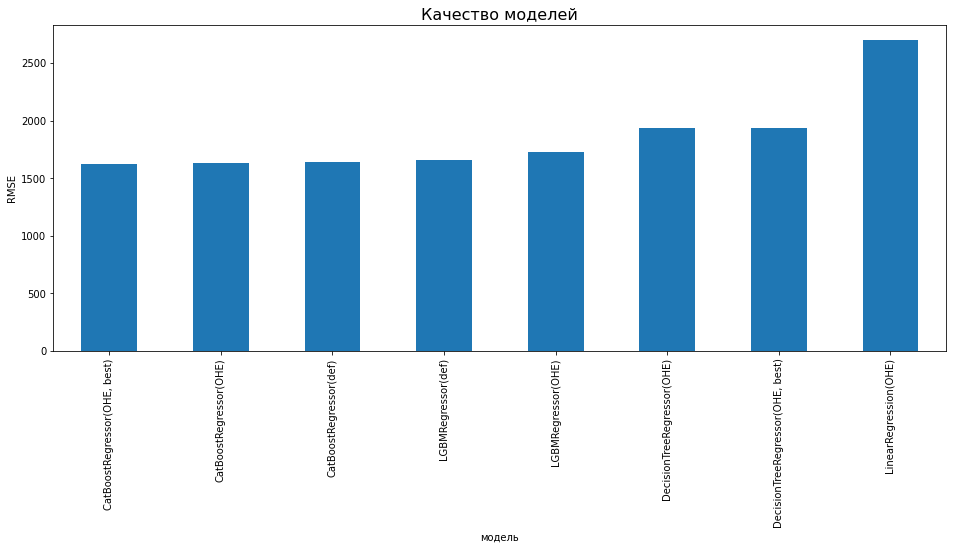

In [40]:
ax = results_df['RMSE'].sort_values().plot(kind='bar', figsize=(16,6))
ax.set_title('Качество моделей', fontsize=16)
ax.set(ylabel='RMSE', xlabel= 'модель')
plt.show;

По качеству модели все имееют примерно одинаковый RMSE в диапозоне от  1500 до  2000

Исключения составили модели линейной регрессии

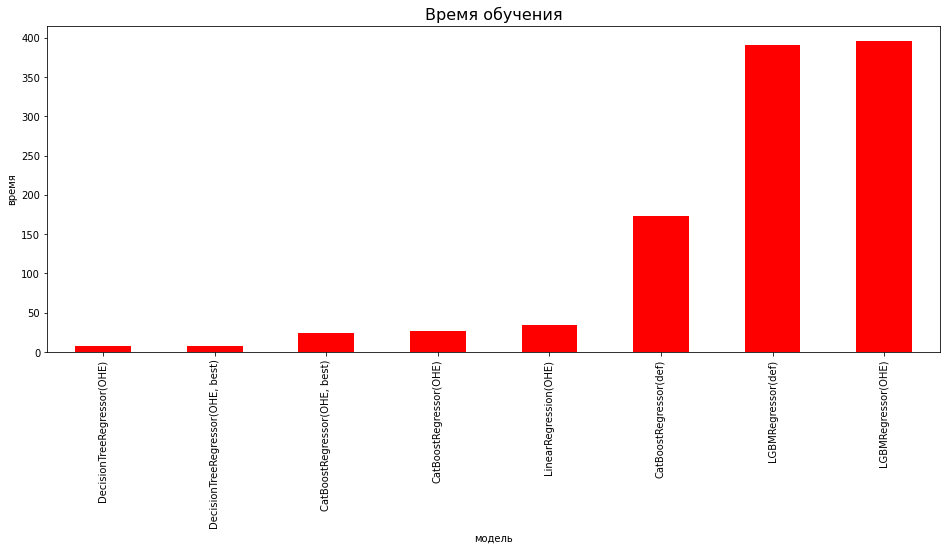

In [41]:
ax = results_df['fit_time'].sort_values().plot(kind='bar', 
                                               figsize=(16,6),
                                               color='r')
ax.set_title('Время обучения', fontsize=16)
ax.set(ylabel='время', xlabel= 'модель')
plt.show;

По скорости обучения,модели линейной регресси занимамют меньше всего времени в то время как бустиговые занимают гораздо бьольшую часть


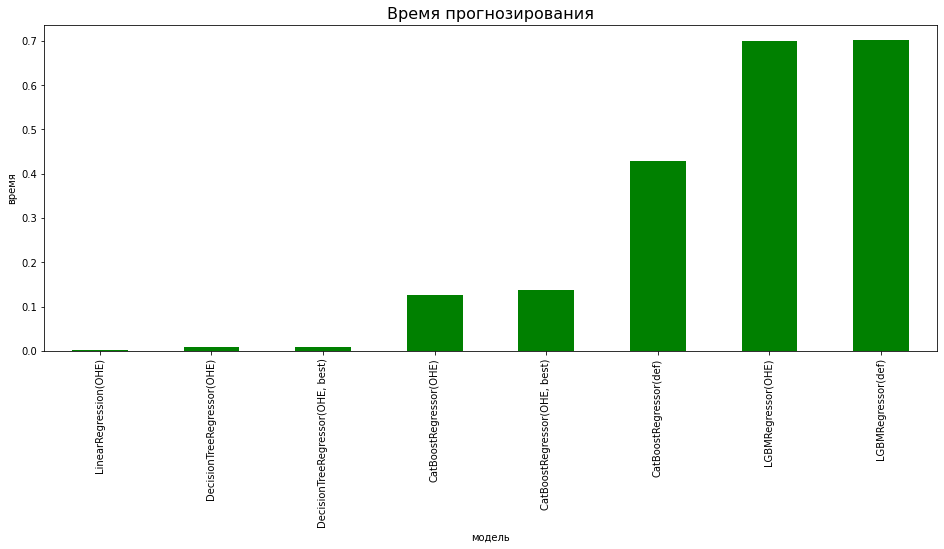

In [42]:
ax = results_df['predict_time'].sort_values().plot(kind='bar', 
                                                   figsize=(16,6),
                                                   color='g')
ax.set_title('Время прогнозирования', fontsize=16)
ax.set(ylabel='время', xlabel= 'модель')
plt.show;

Модели линейной регрессии занимают меньше всего времени на прогноз,дольше всего модель случайного леса

### Тест моделей

In [43]:
test_results = pd.DataFrame(columns=['RMSE', 'fit_time', 'predict_time'])

features_tv = features_train.append(features_valid) # объеденим тренировачную и тестовую выборки
target_tv = target_train.append(target_valid)

In [44]:
test_results.loc['DecisionTreeRegressor'] = get_rmse_valid(DecisionTreeRegressor(max_depth=13, random_state=123),
                                                           preprocessor_OHE,
                                                           features_tv, target_tv, features_test, target_test)

test_results.loc['CatBoostRegressor'] = get_rmse_valid(CatBoostRegressor(silent = True, random_state=123),
                                                       preprocessor_OHE,
                                                       features_tv, target_tv, features_test, target_test)

test_results.loc['LGBMRegressor'] = get_rmse_valid(LGBMRegressor(n_estimators=120, learning_rate=0.1, random_state=123),
                                                   preprocessor_null,
                                                   features_tv, target_tv, features_test, target_test)

test_results.loc['DummyRegressor'] = get_rmse_valid(DummyRegressor(strategy='mean'),
                                                    preprocessor_null,
                                                    features_tv, target_tv, features_test, target_test)
test_results

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,RMSE,fit_time,predict_time
DecisionTreeRegressor,1974.0,7.0,0.00828
CatBoostRegressor,1660.0,34.8,0.12491
LGBMRegressor,1670.3,595.0,0.72818
DummyRegressor,4509.0,0.0,0.00016


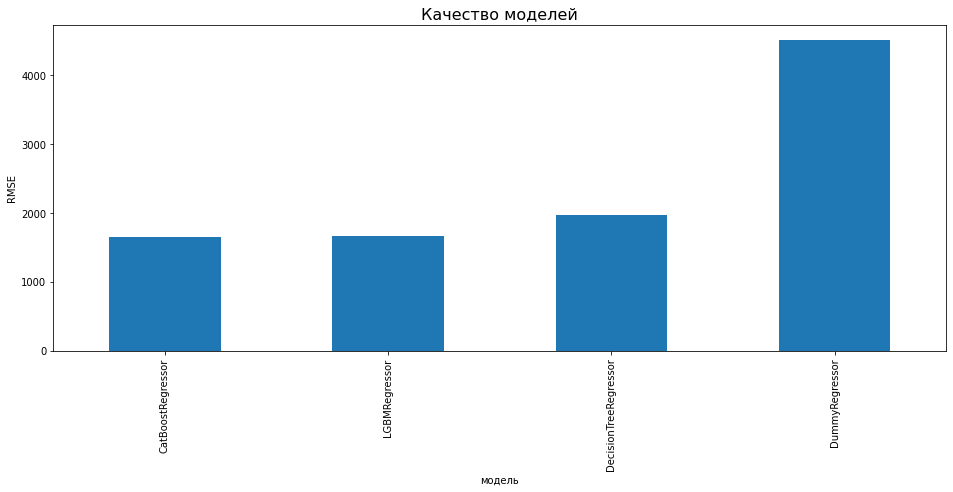

In [45]:
ax = test_results['RMSE'].sort_values().plot(kind='bar', figsize=(16,6))
ax.set_title('Качество моделей', fontsize=16)
ax.set(ylabel='RMSE', xlabel= 'модель')
plt.show;

Качество работы моделей на тестовой выборке соответствует качеству работы на валидационной выборке. Все тестируемые модели выдерживают проверкуу на адекватность в сравнении с константной моделью.

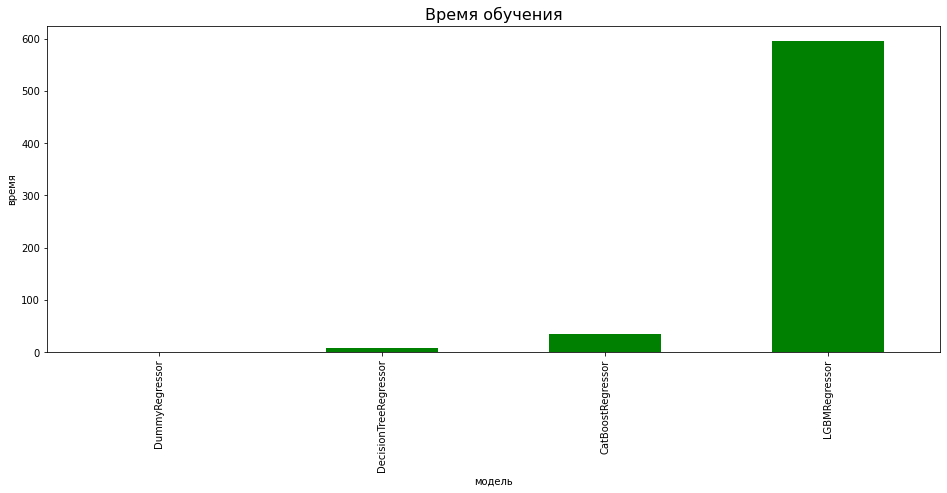

In [46]:
ax = test_results['fit_time'].sort_values().plot(kind='bar', 
                                               figsize=(16,6),
                                               color='g')
ax.set_title('Время обучения', fontsize=16)
ax.set(ylabel='время', xlabel= 'модель')
plt.show;

 Время обучения моделей на тестовой выборке соответствует качеству работы на валидационной выборке

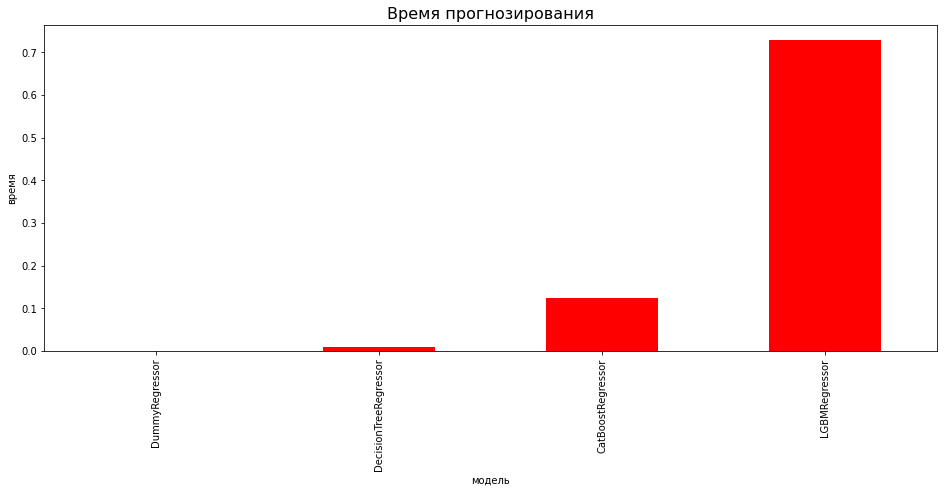

In [47]:
ax = test_results['predict_time'].sort_values().plot(kind='bar', 
                                                   figsize=(16,6),
                                                   color='r')
ax.set_title('Время прогнозирования', fontsize=16)
ax.set(ylabel='время', xlabel= 'модель')
plt.show;

## Общий вывод

На этапе подготовки данных произвели анализ данных. 

- Ценовой диапазон большинства продаваемых на сервисе автомобилей лежит в пределах от 1000 до 6500.

- Основные пользователи сервиса - люди с низкими и средними доходами. 

- В объявлениях присутсвуют практически все брэнды основных автопроизводителей, однако наиболее популярны на сервисе автомобиле европейских производителей. 

- По результатам анализа данных произвели предобработку данных и подготовку выборок к построению моделей.

На этапе обучения моделей было произведено обучение различных моделей, предсказывающих цену автомобиля. 

Обученные модели: 

- линейная регрессия, 
- дерево решений 
- бустинги LightGBM и CatBoost. 

Также, оценили влияние способа кодирования категориальных признаков на качество и время работы моделей. Проанализирована важность признаков.

По результату анализа качества обученных моделей и времени их обучения и прогнозирования можно сделать вывод, что выбор модели для запуска в производство необходимо делать из двух моделей: 

- CatBoostRegressor - если в приоритете точность

- DecisionTreeRegressor если важнее время обучения и прогнозирования.


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей